# Tutorial: fitting a BL Lac broad-band SED using angpy and Gammapy

In order to perform a fit of the broad-band SED of a jetted AGN, `agnpy` includes a `Gammapy` wrapper.
A [Gammapy's `SpectralModel`](https://docs.gammapy.org/0.20/api/gammapy.modeling.models.SpectralModel.html) representing several radiative processes can be defined, and used either to fit flux points or to perform a forward-folding likelihood fit (if the instrument response is available in a format compatible with `Gammapy`). 

Several combination of radiative processes can be used to model the broad-band emission of a jetted AGN. For simplicity, we provide wrappers for the two scenarios most-commonly considered:
* `SycnhrotronSelfComptonSpectralModel`, representing the sum of synchrotron and synchrotron self-Compton radiation. This scenario is commonly considered to model BL Lac sources.
* `ExternalComptonSpectralModel`, representing the sum of synchrotron and synchrotron self-Compton radiation along with an external Compton component that can be computed over a list of targets. This scenario is commonly considered to model flat spectrum radio quasars.


In this tutorial we will show how to use the `SynchrotronSelfComptonSpectralModel` to fit the broad-band SED of Mrk 421, measured by a MWL campaign in 2009 [(Abdo et al. 2011)](https://ui.adsabs.harvard.edu/abs/2011ApJ...736..131A/abstract).

[gammapy](https://gammapy.org/) is required to run this notebook.

In [1]:
# import numpy, astropy and matplotlib for basic functionalities
import pkg_resources
from pathlib import Path
import numpy as np
import astropy.units as u
from astropy.constants import c
from astropy.table import Table
from astropy.coordinates import Distance
import matplotlib.pyplot as plt

# import agnpy classes
from agnpy.spectra import BrokenPowerLaw
from agnpy.emission_regions import Blob
from agnpy.synchrotron import Synchrotron
from agnpy.compton import SynchrotronSelfCompton
from agnpy.wrappers import SynchrotronSelfComptonSpectralModel
from agnpy.utils.plot import load_mpl_rc, sed_x_label, sed_y_label

# import gammapy classes
from gammapy.modeling.models import (SPECTRAL_MODEL_REGISTRY, SkyModel)
from gammapy.estimators import FluxPoints
from gammapy.datasets import Datasets, FluxPointsDataset
from gammapy.modeling import Fit

# IMPORTANT: add the new custom model to the registry of spectral models recognised by gammapy
SPECTRAL_MODEL_REGISTRY.append(SynchrotronSelfComptonSpectralModel)

### `gammapy` wrapper of agnpy synchrotron and SSC
The definition of the `SynchrotronSelfComptonSpectralModel` follows the normal definition of radiative processes in agnpy (see for example the [Synchrotron and SSC tutorial](./synchrotron_self_compton.ipynb)). Therefore only a blob instance is needed to initialise the model.

In [2]:
# total energy content of the electron distribution
spectrum_norm = 5e46 * u.Unit("erg") 
# dictionary describing the electron distribution
spectrum_dict = {
    "type": "BrokenPowerLaw", 
    "parameters": {
        "p1": 2.02,
        "p2": 3.43,
        "gamma_b": 9e4,
        "gamma_min": 500, 
        "gamma_max": 1e6
    }
}
R_b = 2e16 * u.cm
B = 0.1 * u.G
z = 0.0308
delta_D = 20
Gamma = 10
# emission region
blob = Blob(R_b, z, delta_D, Gamma, B, spectrum_norm, spectrum_dict)

# model
ssc_model = SynchrotronSelfComptonSpectralModel(blob)

/home/cosimo/work/agnpy/agnpy/emission_regions/blob.py:166: RuntimeWarning: invalid value encountered in arccos
  self.theta_s = (np.arccos(self.mu_s) * u.rad).to("deg")


In [3]:
print(ssc_model.parameters.to_table())

  type      name     value    unit   error      min       max    frozen is_norm link
-------- --------- ---------- ---- --------- --------- --------- ------ ------- ----
spectral       k_e 3.6707e-08 cm-3 0.000e+00 1.000e-10 1.000e+06  False   False     
spectral        p1 2.0200e+00      0.000e+00 1.000e+00 5.000e+00  False   False     
spectral        p2 3.4300e+00      0.000e+00 1.000e+00 5.000e+00  False   False     
spectral   gamma_b 9.0000e+04      0.000e+00       nan       nan  False   False     
spectral gamma_min 5.0000e+02      0.000e+00 1.000e+00 1.000e+03   True   False     
spectral gamma_max 1.0000e+06      0.000e+00 1.000e+04 1.000e+08   True   False     
spectral         z 3.0800e-02      0.000e+00 1.000e-03 1.000e+01   True   False     
spectral       d_L 4.3094e+26   cm 0.000e+00 1.368e+25 3.271e+29   True   False     
spectral   delta_D 2.0000e+01      0.000e+00 1.000e+00 1.000e+02  False   False     
spectral         B 1.0000e-01    G 0.000e+00 1.000e-04 1.000e+03 

In [4]:
print(ssc_model.spectral_parameters.to_table())

  type      name     value    unit   error      min       max    frozen is_norm link
-------- --------- ---------- ---- --------- --------- --------- ------ ------- ----
spectral       k_e 3.6707e-08 cm-3 0.000e+00 1.000e-10 1.000e+06  False   False     
spectral        p1 2.0200e+00      0.000e+00 1.000e+00 5.000e+00  False   False     
spectral        p2 3.4300e+00      0.000e+00 1.000e+00 5.000e+00  False   False     
spectral   gamma_b 9.0000e+04      0.000e+00       nan       nan  False   False     
spectral gamma_min 5.0000e+02      0.000e+00 1.000e+00 1.000e+03   True   False     
spectral gamma_max 1.0000e+06      0.000e+00 1.000e+04 1.000e+08   True   False     


In [5]:
print(ssc_model.emission_region_parameters.to_table())

  type     name    value    unit   error      min       max    frozen is_norm link
-------- ------- ---------- ---- --------- --------- --------- ------ ------- ----
spectral       z 3.0800e-02      0.000e+00 1.000e-03 1.000e+01   True   False     
spectral     d_L 4.3094e+26   cm 0.000e+00 1.368e+25 3.271e+29   True   False     
spectral delta_D 2.0000e+01      0.000e+00 1.000e+00 1.000e+02  False   False     
spectral       B 1.0000e-01    G 0.000e+00 1.000e-04 1.000e+03  False   False     
spectral     R_b 2.0000e+16   cm 0.000e+00 1.000e+12 1.000e+18  False   False     


### Fit with `gammapy`
Here we start the procedure to fit with `Gammapy`.

#### 1) load the MWL flux points 
The MWL SEDs included in the default `agnpy` data are automatically readable by `Gammapy`'s `FluxPoints`

In [6]:
datasets = Datasets()
flux_points = {}

sed_path = pkg_resources.resource_filename("agnpy", "data/mwl_seds/Mrk421_2011.ecsv")
table = Table.read(sed_path)
table = table.group_by("instrument")

# do not use frequency point below 1e11 Hz, affected by non-blazar emission
E_min_fit = (1e11 * u.Hz).to("eV", equivalencies=u.spectral())

for group in table.groups:
    name = group["instrument"][0]
    
    data = FluxPoints.from_table(group, sed_type="e2dnde", format="gadf-sed")
    dataset = FluxPointsDataset(data=data, name=name)
    
    flux_points.update({name: data})
    dataset.mask_fit = dataset.data.energy_ref > E_min_fit
    datasets.append(dataset)

# load the SSC model in the datasets
model = SkyModel(spectral_model = ssc_model, name="Mrk421")
datasets.models = [model]

No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point 

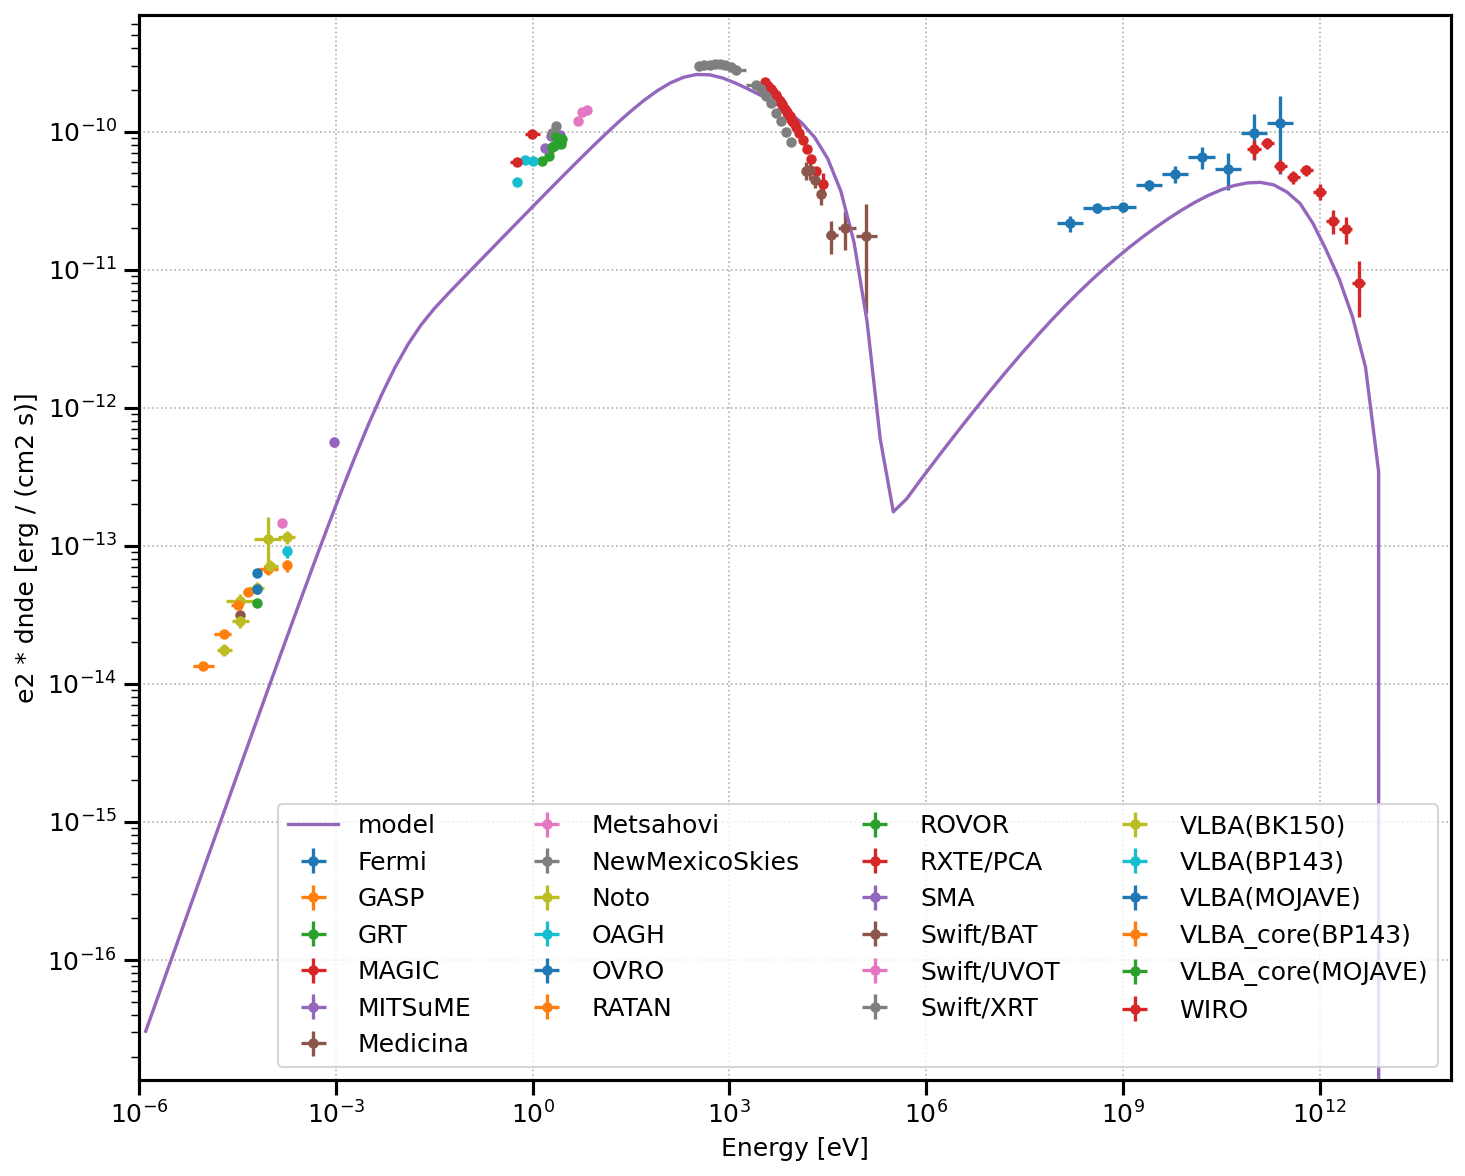

In [9]:
# plot the starting model and the flux points
load_mpl_rc()
fig, ax = plt.subplots(figsize=(10, 8))

for key in flux_points.keys():
    flux_points[key].plot(ax=ax, label=key)

model.spectral_model.plot(energy_bounds=[1e-6, 1e14] * u.eV, energy_power=2, label="model")
    
plt.legend(ncol=4)
plt.xlim([1e-6, 1e14])
plt.show()

In [ ]:
%%time
# define the fitter
fitter = Fit()
results = fitter.run(datasets)
print(results)
print(model.spectral_model.parameters.to_table())

In [ ]:
# plot the final model and the flux points
fig, ax = plt.subplots(figsize=(10, 8))

for key in flux_points.keys():
    flux_points[key].plot(ax=ax, label=key)

model.spectral_model.plot(energy_bounds=[1e-6, 1e14] * u.eV, energy_power=2, label="model")
    
plt.legend(ncol=4)
plt.xlim([1e-6, 1e14])
plt.show()

#### 2) add systematic errors
Currently there is no function in `gammapy` handling systematic errors on flux points.    
Let us manually add different systematic errors in different energy bands.     
We assume them to be independent from the statistical ones and sum the two in quadrature.

In [ ]:
# array of systematic errors, will just be summed in quadrature to the statistical error
# we assume
# - 30% on VHE gamma-ray instruments
# - 10% on HE gamma-ray instruments
# - 10% on X-ray instruments
# - 5% on lower-energy instruments
x = flux_points.table["e_ref"]
y = flux_points.table["e2dnde"]
y_err_stat = flux_points.table["e2dnde_err"]
y_err_syst = np.zeros(len(x))
# define energy ranges
e_vhe = 100 * u.GeV
e_he = 0.1 * u.GeV
e_x_ray_max = 300 * u.keV
e_x_ray_min = 0.3 * u.keV
vhe_gamma = x >= e_vhe
he_gamma = (x >= e_he) * (x < e_vhe)
x_ray = (x >= e_x_ray_min) * (x < e_x_ray_max)
uv_to_radio = x < e_x_ray_min
# declare systematics
y_err_syst[vhe_gamma] = 0.30
y_err_syst[he_gamma] = 0.10
y_err_syst[x_ray] = 0.10
y_err_syst[uv_to_radio] = 0.05
y_err_syst = y * y_err_syst
# sum in quadrature the errors
flux_points.table["e2dnde_err"] = np.sqrt(y_err_stat ** 2 + y_err_syst ** 2)
# convert to "dnde" SED type to fit
flux_points = flux_points.to_sed_type("dnde")

#### 3) perform the fit
Create an instance of the model wrapping the synchrotron and SSC functionalities we defined above.
Let us initialise all the blob parameters with the parameters provided in the paper [(Abdo et al. 2011)](https://ui.adsabs.harvard.edu/abs/2011ApJ...736..131A/abstract). Let us leave free to vary the parameters describing the electron distribution, the Doppler factor and the magnetic field.

Let us define the skymodel and perform the fit

In [ ]:
# define model
model = SkyModel(name="Mrk421_SSC", spectral_model=agnpy_ssc)
dataset_ssc = FluxPointsDataset(model, flux_points)
# do not use frequency point below 1e11 Hz, affected by non-blazar emission
E_min_fit = (1e11 * u.Hz).to("eV", equivalencies=u.spectral())
dataset_ssc.mask_fit = dataset_ssc.data.energy_ref > E_min_fit

#### 4) visualise the fit results

In [ ]:
# plot best-fit model
flux_points.plot(energy_unit="eV", energy_power=2)
agnpy_ssc.plot(energy_range=[1e-6, 1e15] * u.eV, energy_unit="eV", energy_power=2)
plt.show()

In [ ]:
# we can use Gammapy functions to plot the covariance
agnpy_ssc.covariance.plot_correlation()
plt.show()

#### Use `Gammapy` best-fit parameters and `agnpy` to plot the best-fit model specifying its individual components
We fetch the best-fit parameters for our model and we use them to specify and plot the individual spectral components.

In [ ]:
# define the emission region
k_e = 10 ** agnpy_ssc.log10_k_e.value * u.Unit("cm-3")
p1 = agnpy_ssc.p1.value
p2 = agnpy_ssc.p2.value
gamma_b = 10 ** agnpy_ssc.log10_gamma_b.value
gamma_min = 10 ** agnpy_ssc.log10_gamma_min.value
gamma_max = 10 ** agnpy_ssc.log10_gamma_max.value
B = 10 ** agnpy_ssc.log10_B.value * u.G
delta_D = agnpy_ssc.delta_D.value
R_b = (
    c
    * agnpy_ssc.t_var.quantity
    * agnpy_ssc.delta_D.quantity
    / (1 + agnpy_ssc.z.quantity)
).to("cm")
parameters = {
    "p1": p1,
    "p2": p2,
    "gamma_b": gamma_b,
    "gamma_min": gamma_min,
    "gamma_max": gamma_max,
}
spectrum_dict = {"type": "BrokenPowerLaw", "parameters": parameters}
blob = Blob(
    R_b, z, delta_D, delta_D, B, k_e, spectrum_dict, spectrum_norm_type="differential"
)
print(blob)
print(f"jet power in particles: {blob.P_jet_e:.2e}")
print(f"jet power in B: {blob.P_jet_B:.2e}")

In [ ]:
# define the radiative processes
synch = Synchrotron(blob)
ssc = SynchrotronSelfCompton(blob)
# make a finer grid to compute the SED
nu = np.logspace(10, 30, 300) * u.Hz
synch_sed = synch.sed_flux(nu)
ssc_sed = ssc.sed_flux(nu)

In [ ]:
# plot everything
load_mpl_rc()
plt.rcParams["text.usetex"] = True
fig, ax = plt.subplots()
ax.loglog(
    nu / (1 + z),
    synch_sed + ssc_sed,
    ls="-",
    lw=2.1,
    color="crimson",
    label="agnpy, total",
)
ax.loglog(
    nu / (1 + z),
    synch_sed,
    ls="--",
    lw=1.3,
    color="goldenrod",
    label="agnpy, synchrotron",
)
ax.loglog(
    nu / (1 + z), ssc_sed, ls="--", lw=1.3, color="dodgerblue", label="agnpy, SSC"
)
# systematics error in gray
ax.errorbar(
    x.to("Hz", equivalencies=u.spectral()).value,
    y,
    yerr=y_err_syst,
    marker=",",
    ls="",
    color="gray",
    label="",
)
# statistics error in black
ax.errorbar(
    x.to("Hz", equivalencies=u.spectral()).value,
    y,
    yerr=y_err_stat,
    marker=".",
    ls="",
    color="k",
    label="Mrk 421, Abdo et al. (2011)",
)
ax.set_xlabel(sed_x_label)
ax.set_ylabel(sed_y_label)
ax.set_xlim([1e9, 1e29])
ax.set_ylim([1e-14, 1e-9])
ax.legend(loc="best")
plt.show()